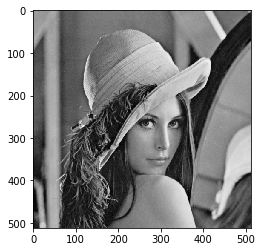

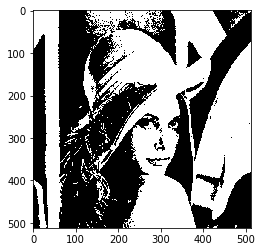

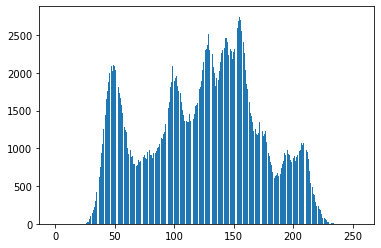

[2688, 2683, 1420, 1678, 2351]
0 511 0 87 255 43
0 511 127 511 255 319
94 237 118 157 165 137
237 287 89 139 262 114
399 511 0 31 455 15


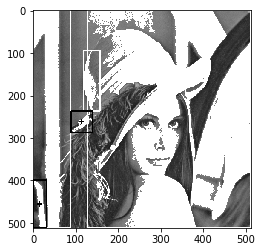

finished all image processing


In [35]:
#!/usr/bin/env python
# coding: utf-8

import cv2
import math, sys
import matplotlib.pyplot as plt
from PIL import Image

'''
savefig sould be done before show
see: https://blog.csdn.net/u010099080/article/details/52912439
'''
LABEL_THRESHOLD = 500
####### hist part ########
def img_hist(img_in):
    hist = [0 for i in range(256)]

    row, col= img_in.shape
    for i in range(0, row):
        for j in range(0, col):
            hist[img_in[i, j]] += 1

    plt.bar(range(0, 256), hist)
    plt.savefig('histogram.png')
    plt.show()
    return 0

####### binarize part ######
def img_binarize(img_in):
    return (img_in > 0x7f) * 0xff

########## IO ##############
img = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap = 'gray')
plt.show()

img_binarized = img_binarize(img)
plt.imshow(img_binarized, cmap = 'gray')
plt.savefig('lena_binarized.png', cmap = 'gray')
plt.show()

img_hist(img)

######### CC part ##########
parent_label = []
cc_img = (img_binarized == 0xff) * 1
rgb_img = cv2.imread('lena.bmp', cv2.IMREAD_COLOR)

def union_find(label):
    original_label = label
    cnt = 0
    row, col = cc_img.shape
    while label != parent_label[label] and cnt < row * col:
        label = parent_label[parent_label[label]]
        cnt += 1

    parent_label[original_label] = label # path compression to avoid TLE
    return label

def draw_rect(u, d, l, r, color):
    cv2.rectangle(rgb_img, (l, u), (r, d), color, 2)

def draw_cent(cen_i, cen_j, color):
    cv2.line(rgb_img, (cen_j - 5, cen_i), (cen_j + 5, cen_i), color, 2)
    cv2.line(rgb_img, (cen_j, cen_i - 5), (cen_j, cen_i + 5), color, 2)

def connected_components():
    # set parent label
    row, col = cc_img.shape
    for i in range(row * col):
        parent_label.append(i)

    # do connected components
    label = 2
    for i in range(row):
        for j in range(col):
            ok1 = 0
            ok2 = 0
            if cc_img[i, j] == 1:
                if j - 1 >= 0 and cc_img[i, j - 1] > 1: # left has already labeled
                    #print(i, j, 'type 1,', end = '')
                    cc_img[i, j] = union_find(cc_img[i, j - 1])
                    ok1 = 1

                if i - 1 >= 0 and cc_img[i - 1, j] > 1: # up has already labeled
                    #print(i, j, 'type 2,', end = '')
                    if ok1: # set the connected component to make left = up
                        parent_label[cc_img[i, j]] = union_find(cc_img[i - 1, j])
                    else:
                        cc_img[i, j] = union_find(cc_img[i - 1, j])

                    ok2 = 1
                if ok2 == 0 and ok1 == 0:
                    #print(i, j, 'type 3,', end = '')
                    cc_img[i, j] = label
                    label += 1
        #print()

    '''
    for i in range(row):
        print()
        for j in range(col):
            print(cc_img[i, j], end = '')

    for i in range(row):
        print()
        for j in range(col):
            print(cc_img[i, j], end = '')
    '''

    # union and find merging
    for i in range(row):
        for j in range(col):
            if cc_img[i, j] > 1:
                #print('%d par--> %d,' %(cc_img[i, j], union_find(cc_img[i, j])), end = '')
                cc_img[i, j] = union_find(cc_img[i, j])

    mymap = [0 for i in range (row * col)]

    # statistical data for label threshold > 500
    for i in range(0, row):
        for j in range(0, col):
            mymap[cc_img[i, j]] += 1

    cc_pos = {}
    cc_value = []
    for i in range(0, row):
        for j in range(0, col):
            if cc_img[i, j] and cc_img[i, j] not in cc_value and mymap[cc_img[i, j]] > LABEL_THRESHOLD:
                cc_value.append(cc_img[i, j])
    
    # change the rgb image to black and white and add draw rectangle and cross
    print(cc_value)
    for i in cc_value:
        cc_pos[i] = []
        
        
    for i in range(0, row):
        for j in range(0, col):
            if cc_img[i, j] and mymap[cc_img[i, j]] > LABEL_THRESHOLD:
                cc_pos[cc_img[i, j]].append((i, j))
                if cc_img[i, j]:
                    rgb_img[i, j] = (255, 255, 255) 
                else:
                    rgb_img[i, j] = (0, 0, 0) 
                    
                
    rainbow = [(255, 0, 0), (255, 127, 0), (255, 255, 0), (0, 255, 0), (0, 0, 255), (148, 0, 211)]
    rainbow_idx = 0
    
    for each_cc_value in cc_value:
        u = min(cc_pos[each_cc_value], key = lambda i : i [0])[0]
        d = max(cc_pos[each_cc_value], key = lambda i : i [0])[0]
        l = min(cc_pos[each_cc_value], key = lambda i : i [1])[1]
        r = max(cc_pos[each_cc_value], key = lambda i : i [1])[1]
        
        cen_i = (u + d) // 2
        cen_j = (l + r) // 2
        
        print(u, d, l, r, cen_i, cen_j)
        draw_rect(u, d, l, r, rainbow[rainbow_idx])
        draw_cent(cen_i, cen_j, rainbow[rainbow_idx])
        rainbow_idx += 1
        
            
connected_components()
plt.imshow(rgb_img)
plt.savefig('lena_connected_components.png')
plt.show()
print('finished all image processing')

